## METRICS ANALYSIS OF WIKISPEEDIA GRAPH

In [28]:
import collections
from networkx.algorithms.community import greedy_modularity_communities
import pandas as pd
from urllib.parse import unquote
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from community import community_louvain
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from community import community_louvain
import networkx as nx
from collections import Counter

Load and prepare data

In [29]:
data_folder = "wikispeedia_paths-and-graph"

articles_df = pd.read_csv(f"{data_folder}/articles.tsv", sep="\t", header=None, names=["Article"])
links_df = pd.read_csv(f"{data_folder}/links.tsv", sep="\t", comment="#", header=None, names=["From", "To"])
paths_df = pd.read_csv(f"{data_folder}/paths_finished.tsv", sep="\t", comment="#", header=None,
                       names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])
categories_df = pd.read_csv(f"{data_folder}/categories.tsv", sep="\t", header=None, names=["Node", "Category"])

# STEP 2: Decode article names (URL decoding)
links_df["From"] = links_df["From"].apply(unquote)
links_df["To"] = links_df["To"].apply(unquote)

Build Directed Graph

In [30]:
G = nx.from_pandas_edgelist(links_df, source="From", target="To", create_using=nx.DiGraph())

print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph built with 4592 nodes and 119882 edges.


Structural Analysis

In [4]:
print("\n--- Structural Analysis ---")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
print("Strongly Connected Components:", nx.number_strongly_connected_components(G))
print("Weakly Connected Components:", nx.number_weakly_connected_components(G))

# Density: how tightly connected the graph is
print("Graph Density:", nx.density(G))

# Assortativity: correlation between degrees of connected nodes
print("Degree Assortativity:", nx.degree_assortativity_coefficient(G))

# Reciprocity: how often links are bidirectional
print("Reciprocity:", nx.reciprocity(G))

# STEP 5: Centrality analysis
print("\n--- Centrality Measures ---")
# In-degree and out-degree
in_deg = nx.in_degree_centrality(G)
out_deg = nx.out_degree_centrality(G)

# PageRank (better than eigenvector for directed)
pagerank = nx.pagerank(G)

# Betweenness
bet_cent = nx.betweenness_centrality(G)

# Closeness (use directed)
clo_cent = nx.closeness_centrality(G)

# Top 5 nodes by PageRank
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 by PageRank:")
for node, score in top_pagerank:
    print(f"{node}: {score:.4f}")

betweeness = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 by Betweeness:")
for node, score in betweeness:
    print(f"{node}: {score:.4f}")

print("\n--- In-Degree (Top 10 Nodes) ---")
in_degrees = dict(G.in_degree())
top_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
for node, degree in top_in:
    print(f"{node}: in-degree = {degree}")

print("\n--- Out-Degree (Top 10 Nodes) ---")
out_degrees = dict(G.out_degree())
top_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
for node, degree in top_out:
    print(f"{node}: out-degree = {degree}")


--- Structural Analysis ---
Nodes: 4592
Edges: 119882
Strongly Connected Components: 519
Weakly Connected Components: 2
Graph Density: 0.005686496910710776
Degree Assortativity: -0.05620919781872192
Reciprocity: 0.2208004537795499

--- Centrality Measures ---
Top 5 by PageRank:
United_States: 0.0096
France: 0.0064
Europe: 0.0063
United_Kingdom: 0.0062
English_language: 0.0049
Top 5 by Betweeness:
United_States: 0.0941
United_Kingdom: 0.0424
England: 0.0324
Europe: 0.0270
Africa: 0.0242

--- In-Degree (Top 10 Nodes) ---
United_States: in-degree = 1551
United_Kingdom: in-degree = 972
France: in-degree = 959
Europe: in-degree = 933
World_War_II: in-degree = 751
England: in-degree = 751
Germany: in-degree = 743
India: in-degree = 611
English_language: in-degree = 598
London: in-degree = 587

--- Out-Degree (Top 10 Nodes) ---
United_States: out-degree = 294
Driving_on_the_left_or_right: out-degree = 255
List_of_countries: out-degree = 244
List_of_circulating_currencies: out-degree = 236
Li

Simple subgraph plot

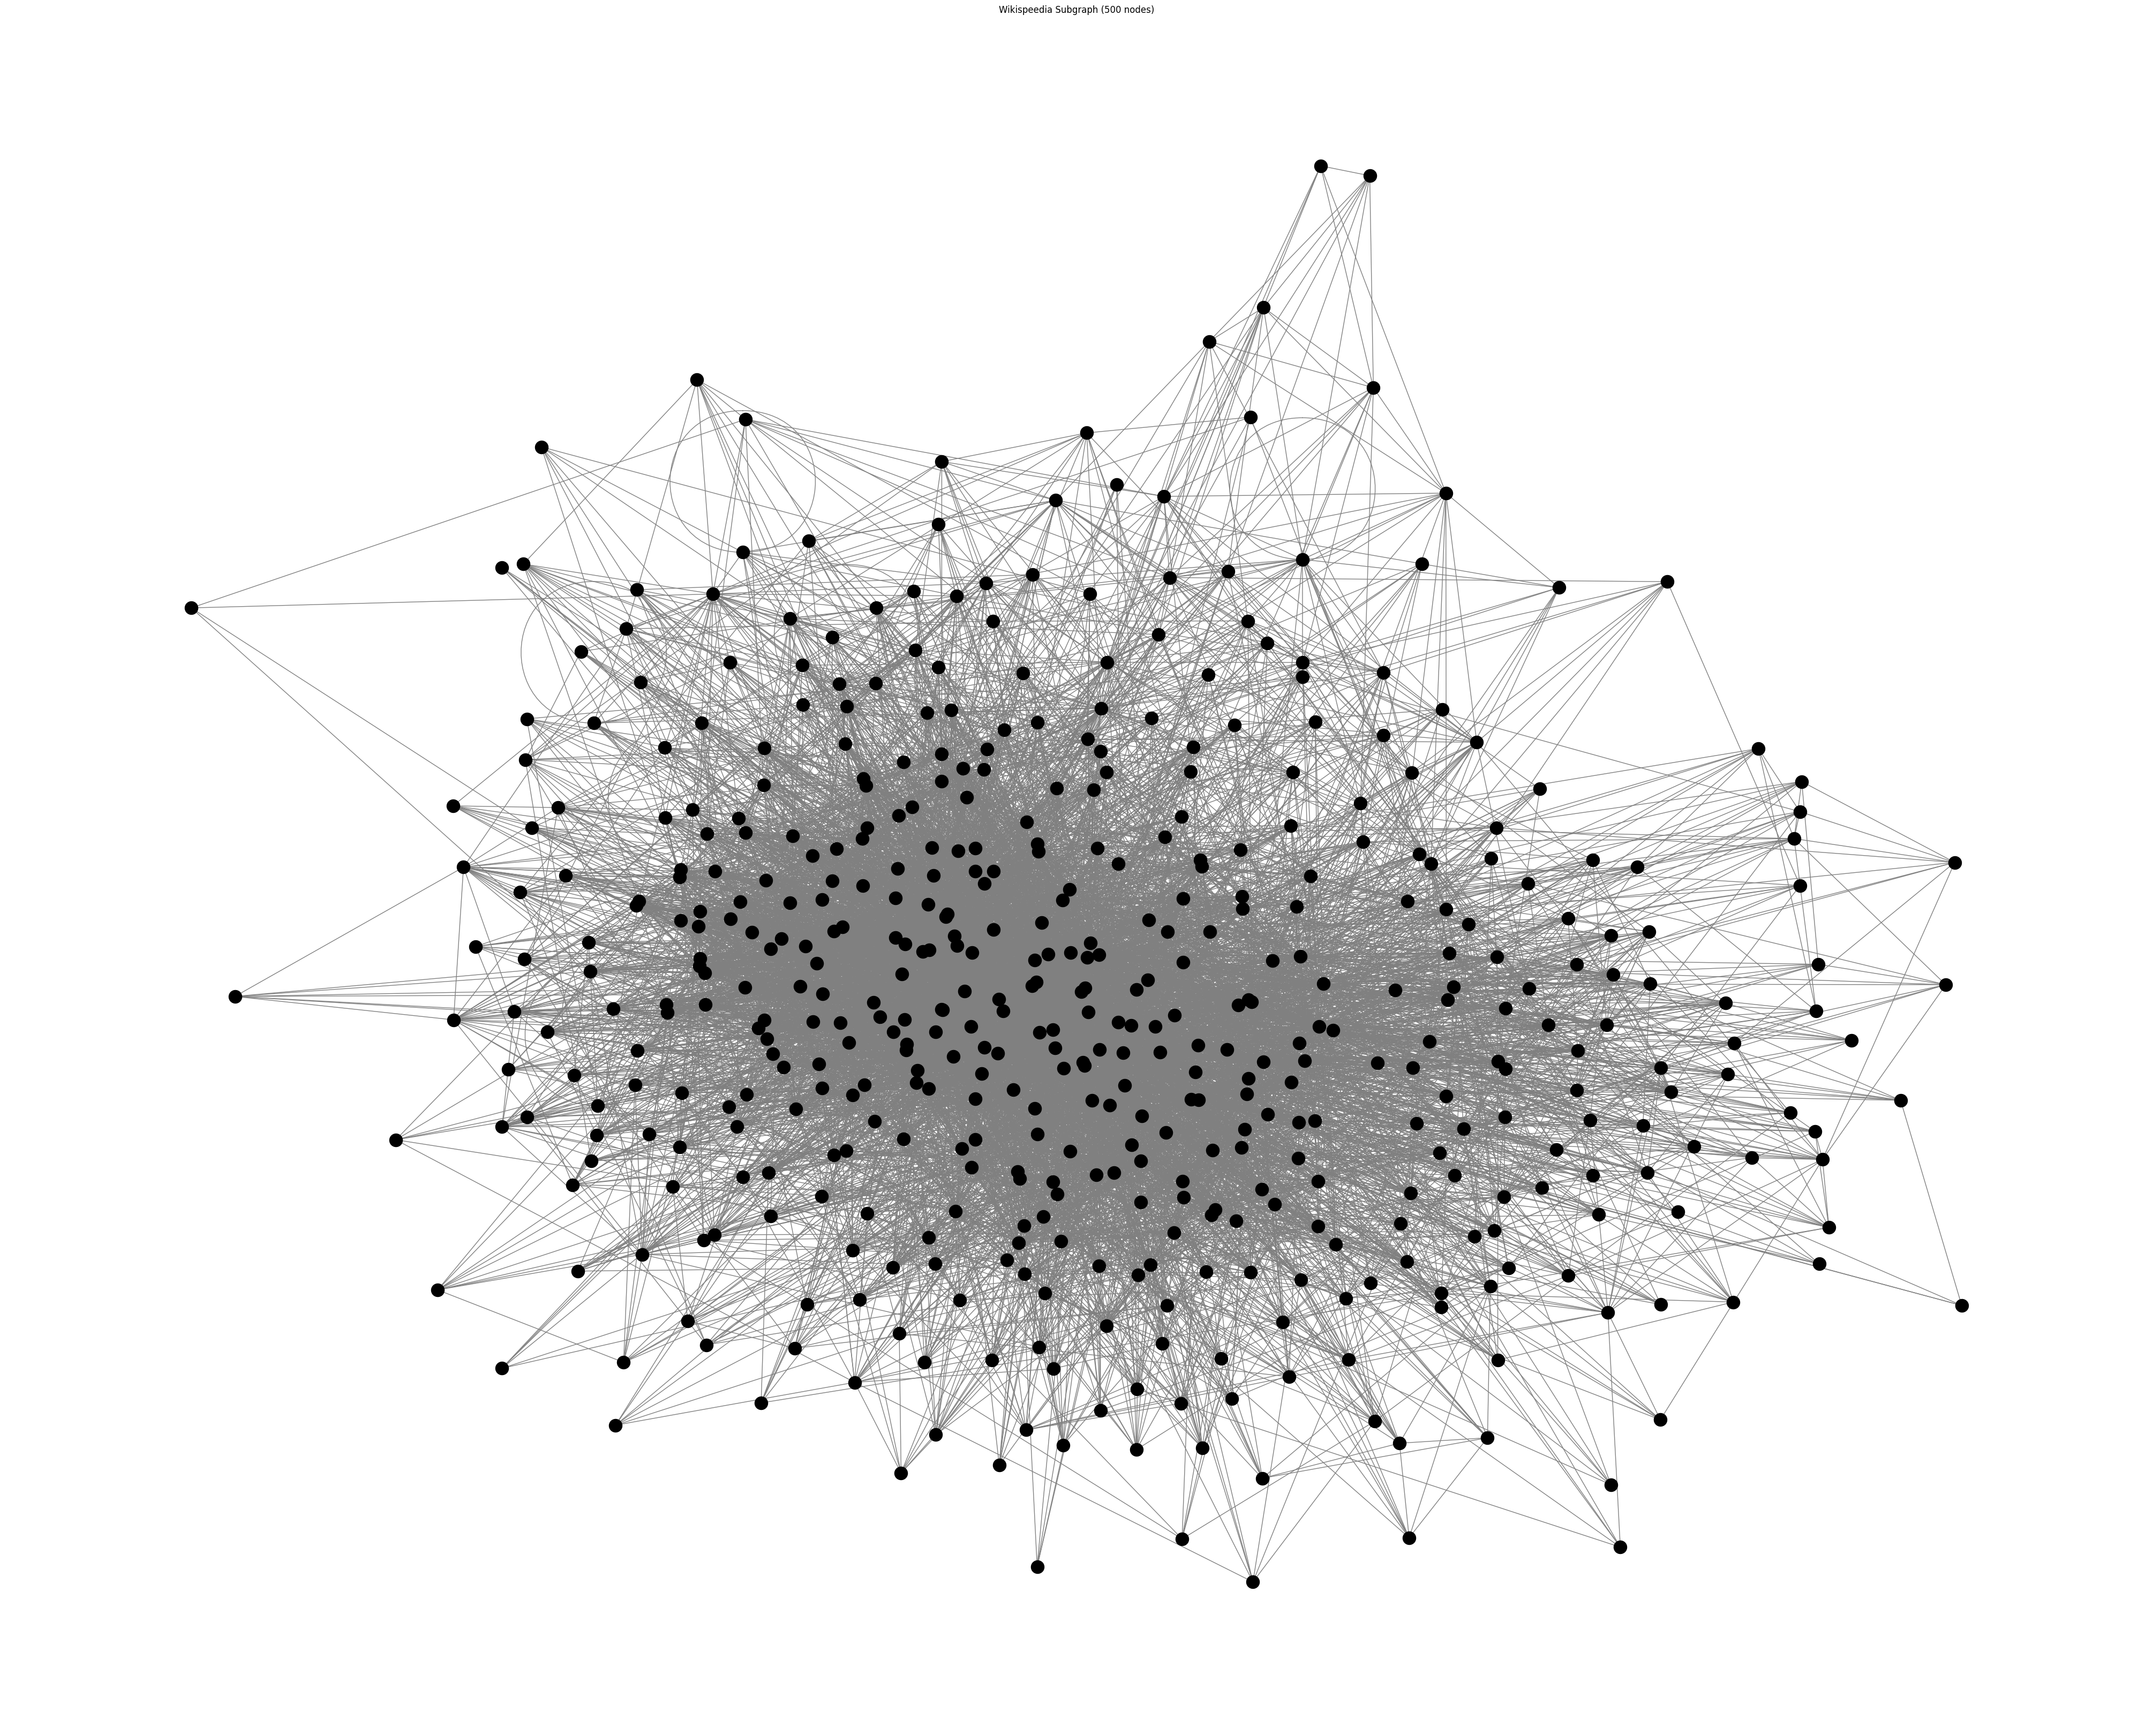

In [6]:
sample_nodes = list(G.nodes)[:500]
subG = G.subgraph(sample_nodes)

plt.figure(figsize=(40, 32))
nx.draw(subG.to_undirected(), node_size=300, node_color='black', edge_color='gray', with_labels=False)
plt.title("Wikispeedia Subgraph (500 nodes)")
plt.show()
plt.close()


LOUVAIN COMMUNITIES

In [25]:
print("\n--- Louvain Community Analysis ---")
# 1. Compute Louvain partition (node → community id)
partition = community_louvain.best_partition(undirected_G)

# 2. Invert partition: community_id → set of nodes
community_nodes = {}
for node, comm_id in partition.items():
    community_nodes.setdefault(comm_id, set()).add(node)

# 3. Sort communities by size
sorted_communities = sorted(community_nodes.items(), key=lambda x: len(x[1]), reverse=True)

# 4. Analyze top 5 communities
for i, (comm_id, nodes) in enumerate(sorted_communities[:5], start=1):
    subgraph = undirected_G.subgraph(nodes)
    size = len(nodes)
    density = nx.density(subgraph)
    clustering = nx.average_clustering(subgraph)

    # Top theme
    themes = [category_map[node] for node in nodes if node in category_map]
    if themes:
        top_theme, count = Counter(themes).most_common(1)[0]
    else:
        top_theme, count = "N/A", 0

    # Top nodes (by degree)
    degrees = sorted(subgraph.degree, key=lambda x: x[1], reverse=True)[:3]
    top_nodes = [node for node, _ in degrees]

    print(f"\nCommunity {i}:")
    print(f"- Size: {size}")
    print(f"- Top theme: {top_theme} (count: {count})")
    print(f"- Density: {density:.3f}")
    print(f"- Average clustering: {clustering:.2f}")
    print(f"- Top nodes: {', '.join(top_nodes)}")


--- Louvain Community Analysis ---

Community 1:
- Size: 765
- Top theme: subject.Science.Biology.Birds (count: 155)
- Density: 0.026
- Average clustering: 0.40
- Top nodes: Scientific_classification, Animal, Chordate

Community 2:
- Size: 763
- Top theme: subject.Design_and_Technology.Railway_transport (count: 55)
- Density: 0.023
- Average clustering: 0.40
- Top nodes: United_States, New_York_City, Canada

Community 3:
- Size: 739
- Top theme: subject.Countries (count: 125)
- Density: 0.053
- Average clustering: 0.38
- Top nodes: India, Africa, English_language

Community 4:
- Size: 693
- Top theme: subject.Geography.European_Geography (count: 53)
- Density: 0.040
- Average clustering: 0.40
- Top nodes: France, Germany, Italy

Community 5:
- Size: 644
- Top theme: subject.Science.Chemistry.Chemical_elements (count: 115)
- Density: 0.043
- Average clustering: 0.38
- Top nodes: Earth, Electron, Sun


SPECTRAL CLUSTERING

In [13]:
import networkx as nx
from community import community_louvain
from sklearn.cluster import SpectralClustering
from collections import Counter

# 1. Compute Louvain partition to get number of communities
partition = community_louvain.best_partition(undirected_G)
n_clusters = len(set(partition.values()))

# 2. Build the full adjacency matrix on the same undirected_G
#    (SpectralClustering with affinity='precomputed' expects an adjacency-like matrix)
adj_matrix = nx.to_numpy_array(undirected_G)

# 3. Run spectral clustering with the same k as Louvain
spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=42
)
labels = spectral.fit_predict(adj_matrix)

# 4. Assign nodes to spectral clusters
node_list = list(undirected_G.nodes())
spectral_communities = {}
for node, lbl in zip(node_list, labels):
    spectral_communities.setdefault(lbl, set()).add(node)

# 5. Sort spectral communities by size and print top 5
sorted_spectral = sorted(
    spectral_communities.items(),
    key=lambda x: len(x[1]),
    reverse=True
)

for i, (lbl, nodes) in enumerate(sorted_spectral[:5], start=1):
    subg = undirected_G.subgraph(nodes)
    size = len(nodes)
    density = nx.density(subg)
    clustering = nx.average_clustering(subg)

    # Top theme
    themes = [category_map[n] for n in nodes if n in category_map]
    if themes:
        top_theme, count = Counter(themes).most_common(1)[0]
    else:
        top_theme, count = "N/A", 0

    # Top 3 nodes by degree
    top_nodes = sorted(subg.degree, key=lambda x: x[1], reverse=True)[:3]
    top_nodes = [n for n, _ in top_nodes]

    print(f"\nSpectral Community {i}:")
    print(f"- Size: {size}")
    print(f"- Top theme: {top_theme} (count: {count})")
    print(f"- Density: {density:.3f}")
    print(f"- Average clustering: {clustering:.2f}")
    print(f"- Top nodes: {', '.join(top_nodes)}")


/Users/jimroidis/PycharmProjects/Graph Analysis and Connection Prediction/.venv/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



Spectral Community 1:
- Size: 2704
- Top theme: subject.Countries (count: 131)
- Density: 0.016
- Average clustering: 0.29
- Top nodes: United_States, United_Kingdom, Europe

Spectral Community 2:
- Size: 942
- Top theme: subject.Geography.Geography_of_Great_Britain (count: 98)
- Density: 0.023
- Average clustering: 0.32
- Top nodes: England, London, Scotland

Spectral Community 3:
- Size: 450
- Top theme: subject.Science.Biology.Birds (count: 151)
- Density: 0.037
- Average clustering: 0.57
- Top nodes: Animal, Scientific_classification, Chordate

Spectral Community 4:
- Size: 219
- Top theme: subject.Science.Chemistry.Chemical_elements (count: 113)
- Density: 0.134
- Average clustering: 0.47
- Top nodes: Phase_(matter), Electron, Periodic_table

Spectral Community 5:
- Size: 184
- Top theme: subject.Science.Physics.Space_Astronomy (count: 90)
- Density: 0.098
- Average clustering: 0.46
- Top nodes: Sun, Star, Gravitation


GRAPH PLOT with SPECTRAL CLUSTERING applied

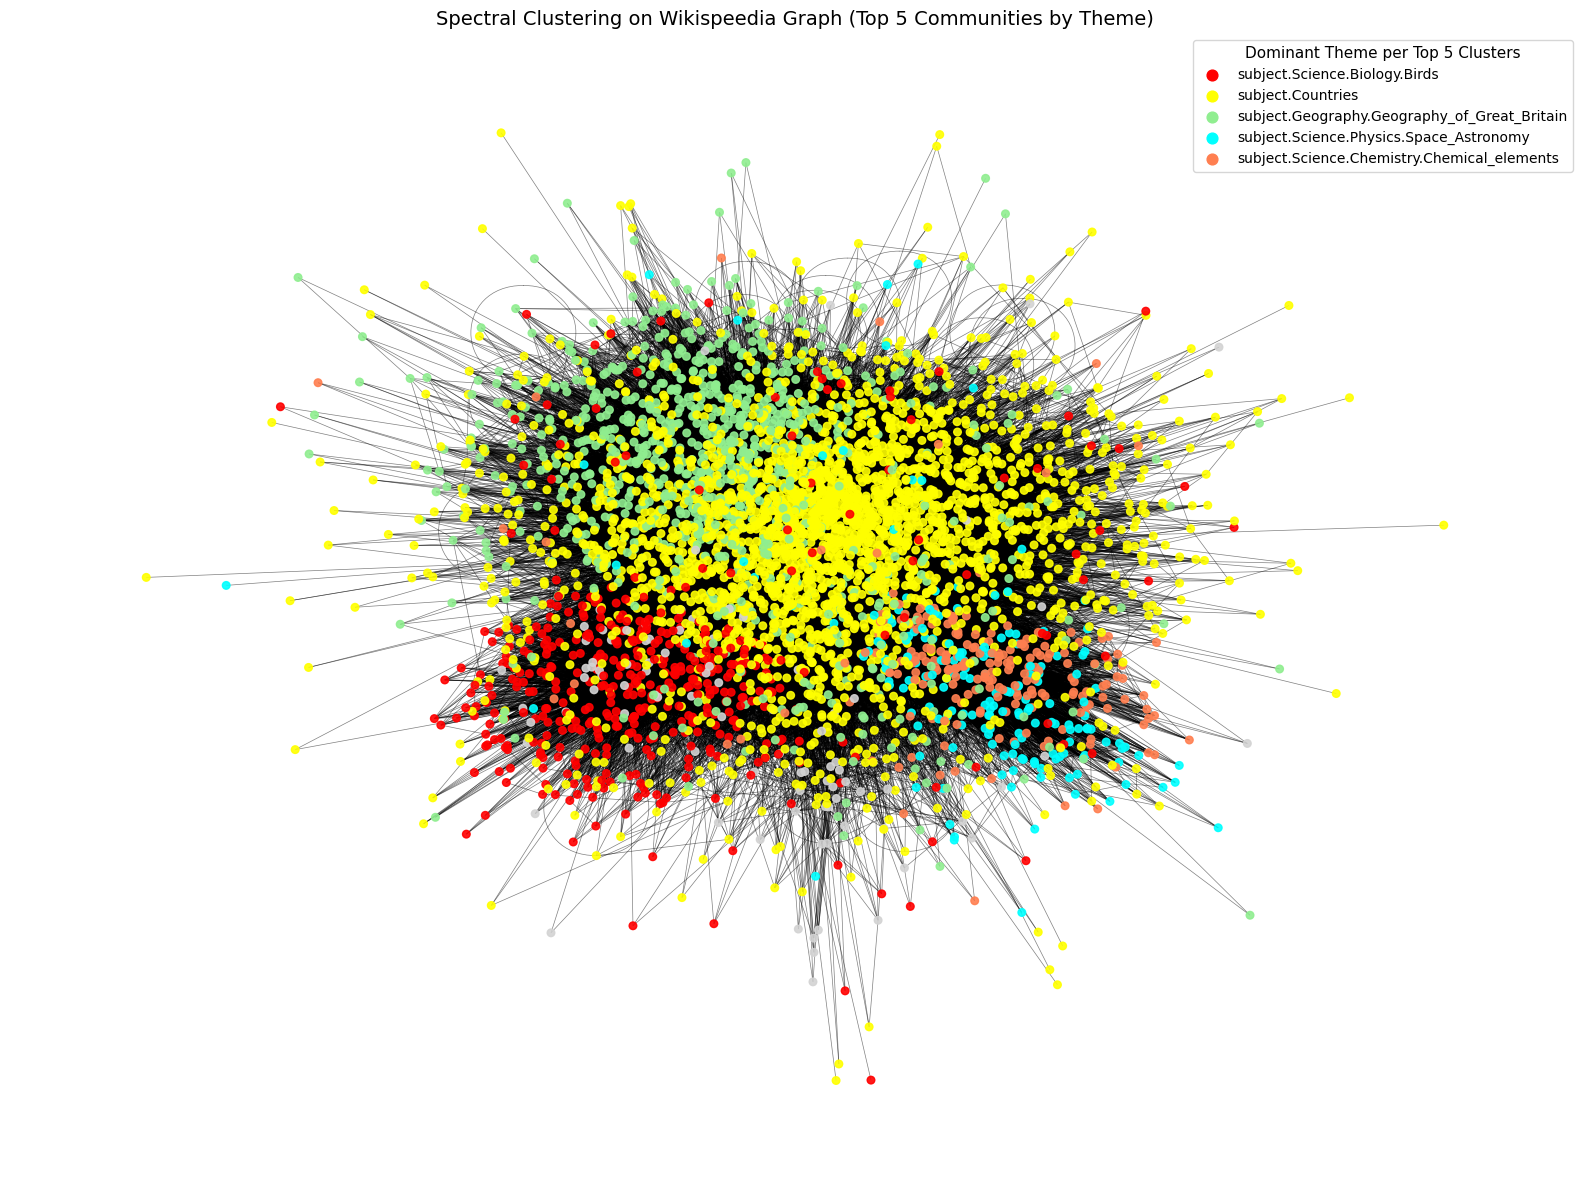

In [27]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
from collections import Counter

# === Assign cluster label to each node ===
node_cluster = dict(zip(node_list, labels))

# === Rebuild clusters: cluster_id → list of nodes ===
clusters = {}
for node, cluster_id in node_cluster.items():
    clusters.setdefault(cluster_id, []).append(node)

# === Sort clusters by size and keep top 5 ===
sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)
top5_clusters = sorted_clusters[:5]
top5_cluster_ids = {cluster_id for cluster_id, _ in top5_clusters}

# === Determine dominant theme for each of the top 5 clusters ===
cluster_themes = {}
for cluster_id, cluster_nodes in top5_clusters:
    themes = [category_map.get(node) for node in cluster_nodes if node in category_map]
    top = Counter(themes).most_common(1)
    if top:
        cluster_themes[cluster_id] = top[0][0]
    else:
        cluster_themes[cluster_id] = f"Cluster {cluster_id}"

# === Assign each theme a unique color ===
unique_themes = list(set(cluster_themes.values()))
custom_colors = ["red", "yellow", "lightgreen", "cyan", "coral"]
theme_color_map = {theme: custom_colors[i % len(custom_colors)] for i, theme in enumerate(unique_themes)}

# === Map node to theme color (only top 5 clusters get specific colors) ===
default_color = "lightgray"
node_colors = []
for node in Gcc.nodes():
    cluster_id = node_cluster[node]
    if cluster_id in top5_cluster_ids:
        theme = cluster_themes[cluster_id]
        color = theme_color_map[theme]
    else:
        color = default_color
    node_colors.append(color)

# === Plotting ===
pos = nx.spring_layout(Gcc, seed=42)
plt.figure(figsize=(16, 12))
nx.draw_networkx_edges(Gcc, pos, edge_color="black", alpha=0.5, width=0.5)
nx.draw_networkx_nodes(Gcc, pos, node_color=node_colors, node_size=30, alpha=0.9)

# Add legend for top 5 themes
for theme, color in theme_color_map.items():
    plt.scatter([], [], color=color, label=theme, s=60)
plt.legend(title="Dominant Theme per Top 5 Clusters", fontsize=10, title_fontsize=11)

plt.title("Spectral Clustering on Wikispeedia Graph (Top 5 Communities by Theme)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


GRAPH PLOT based on PAGERANK

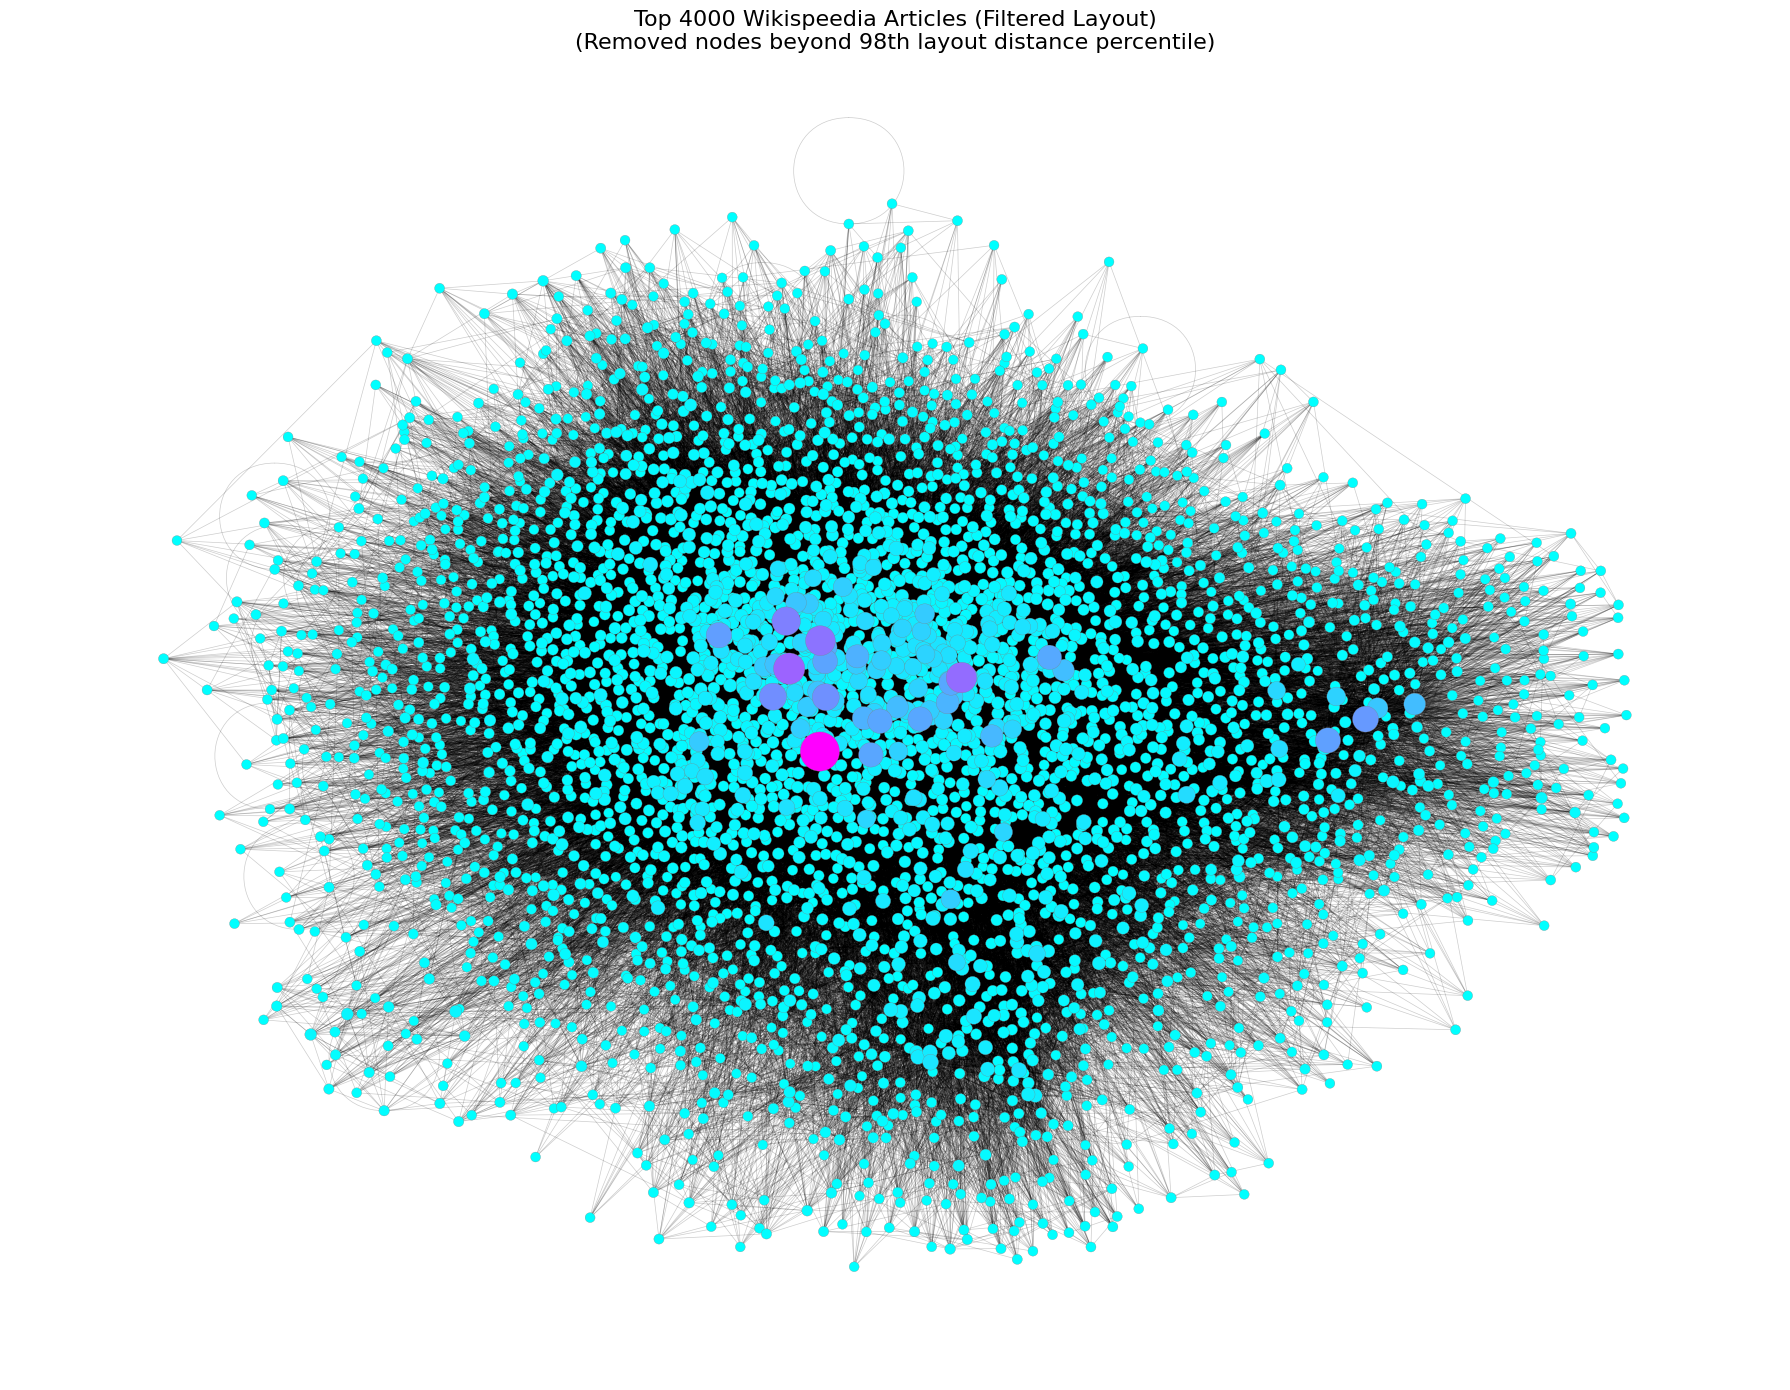

In [36]:
def visualize_wikispeedia_clean(
    G,
    pagerank=None,
    top_n=4000,
    path="wikispeedia_clean_graph.png",
    show=True,
    save=False,
    distance_percentile=98  # Filter out nodes above this layout distance percentile
):
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from sklearn.preprocessing import MinMaxScaler
    from scipy.spatial.distance import cdist

    if pagerank is None:
        pagerank = nx.pagerank(G)

    # Step 1: Select top-N nodes by PageRank
    sorted_pr = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
    top_nodes = [n for n, _ in sorted_pr[:top_n]]
    subG = G.subgraph(top_nodes).copy()

    # Step 2: Compute spring layout
    pos = nx.spring_layout(subG, seed=42, k=0.15, iterations=100)

    # Step 3: Filter out distant nodes
    coords = np.array(list(pos.values()))
    center = coords.mean(axis=0)
    distances = np.linalg.norm(coords - center, axis=1)
    threshold = np.percentile(distances, distance_percentile)

    keep_nodes = [
        node for node, dist in zip(pos.keys(), distances)
        if dist <= threshold
    ]

    filtered_subG = subG.subgraph(keep_nodes).copy()
    pos_filtered = {n: pos[n] for n in filtered_subG.nodes()}

    # Step 4: Scale PageRank for size
    pr_vals = np.array([pagerank[n] for n in filtered_subG.nodes()])
    sizes = MinMaxScaler((50, 800)).fit_transform(pr_vals.reshape(-1, 1)).flatten()

    # Step 5: Sorted for consistent coloring
    nodes_sorted = sorted(filtered_subG.nodes(), key=lambda n: pagerank[n])
    pr_sorted = np.array([pagerank[n] for n in nodes_sorted])
    normalized = MinMaxScaler((0, 1)).fit_transform(pr_sorted.reshape(-1, 1)).flatten()
    node_colors = [cm.cool(v) for v in normalized]

    fig, ax = plt.subplots(figsize=(18, 14))

    nx.draw_networkx_edges(
        filtered_subG, pos_filtered,
        edge_color="black",
        alpha=0.2,
        width=0.5,
        ax=ax
    )

    node_index_map = {n: i for i, n in enumerate(filtered_subG.nodes())}
    node_sizes = [sizes[node_index_map[n]] for n in nodes_sorted]

    nx.draw_networkx_nodes(
        filtered_subG, pos_filtered,
        nodelist=nodes_sorted,
        node_size=node_sizes,
        node_color=node_colors,
        edgecolors="grey",
        linewidths=0.2,
        ax=ax
    )

    ax.set_title(
        f"Top {top_n} Wikispeedia Articles (Filtered Layout)\n"
        f"(Removed nodes beyond {distance_percentile}th layout distance percentile)",
        fontsize=16
    )
    ax.axis("off")
    plt.tight_layout()

    if show:
        plt.show()

    if save:
        fig.savefig(path, dpi=300, bbox_inches="tight")


visualize_wikispeedia_clean(
    G,
    show=True,
    save=False,
    distance_percentile=98  # Filter out nodes above this layout distance percentile
)

INTUITIONS ON PLAYERS' BEHAVIOR

In [28]:
print("\n--- Behavioral Analysis from Paths ---")

# Drop rows with missing paths
paths_df = paths_df.dropna(subset=["path"])

# Parse paths
paths_df["ArticlePath"] = paths_df["path"].apply(lambda x: x.split(";"))

# Compute basic stats
total_paths = len(paths_df)
avg_length = paths_df["ArticlePath"].apply(len).mean()
avg_duration = paths_df["durationInSec"].mean()

print(f"Total navigation paths: {total_paths}")
print(f"Average path length (in hops): {avg_length:.2f}")
print(f"Average time spent (in seconds): {avg_duration:.2f}")

# Most common start and end articles
start_counts = paths_df["ArticlePath"].apply(lambda x: x[0]).value_counts()
end_counts = paths_df["ArticlePath"].apply(lambda x: x[-1]).value_counts()

print("\nTop 5 Starting Articles:")
for article, count in start_counts.head(5).items():
    print(f"{article}: {count} paths")

print("\nTop 5 Ending Articles:")
for article, count in end_counts.head(5).items():
    print(f"{article}: {count} paths")

# Top visited articles overall (not just start/end)
from collections import Counter
all_articles = paths_df["ArticlePath"].explode()
top_visited = Counter(all_articles).most_common(5)

print("\nTop 5 Most Visited Articles Overall:")
for article, count in top_visited:
    print(f"{article}: {count} appearances")


--- Behavioral Analysis from Paths ---
Total navigation paths: 51318
Average path length (in hops): 6.76
Average time spent (in seconds): 158.28

Top 5 Starting Articles:
Brain: 1092 paths
Asteroid: 1059 paths
Theatre: 931 paths
Pyramid: 674 paths
Batman: 602 paths

Top 5 Ending Articles:
Telephone: 1134 paths
Viking: 1071 paths
Zebra: 955 paths
Bean: 673 paths
Adolf_Hitler: 603 paths

Top 5 Most Visited Articles Overall:
<: 20561 appearances
United_States: 8896 appearances
Europe: 4362 appearances
United_Kingdom: 3904 appearances
England: 3332 appearances



--- Path Efficiency Analysis ---
Average efficiency (shortest/actual): 0.528
Average detour (actual - shortest): 3.39

Top 5 Most Common Article Transitions:
< → <: 4971 times
Communication → Telephone: 533 times
North_America → United_States: 492 times
Animal → Mammal: 487 times
Lion → Zebra: 472 times

Top 3 End Articles by Number of Unique Paths:
Telephone: 615 unique paths (out of 1134 total)
Viking: 787 unique paths (out of 1071 total)
Zebra: 649 unique paths (out of 955 total)

--- Path Length vs. Average Duration ---


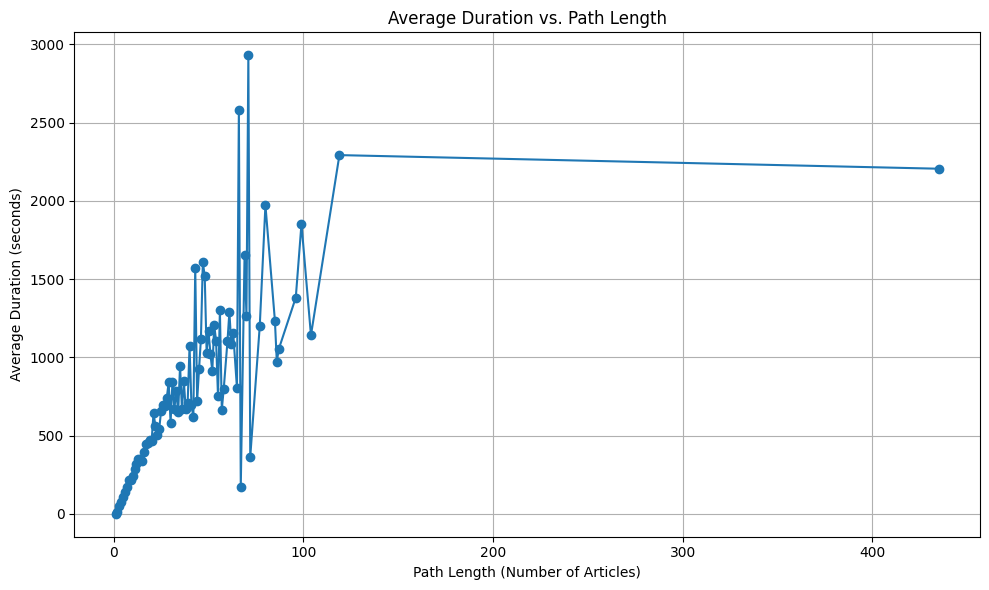

In [29]:
print("\n--- Path Efficiency Analysis ---")

shortest_lengths = []
actual_lengths = []

for path in paths_df["ArticlePath"]:
    if len(path) < 2:
        continue
    start, end = path[0], path[-1]
    try:
        shortest = nx.shortest_path_length(G, source=start, target=end)
        actual = len(path) - 1
        shortest_lengths.append(shortest)
        actual_lengths.append(actual)
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        continue

if shortest_lengths:
    efficiency = [s / a for s, a in zip(shortest_lengths, actual_lengths) if a != 0]
    print(f"Average efficiency (shortest/actual): {sum(efficiency)/len(efficiency):.3f}")
    print(f"Average detour (actual - shortest): {sum(a - s for s, a in zip(shortest_lengths, actual_lengths)) / len(shortest_lengths):.2f}")

bigrams = Counter()
for path in paths_df["ArticlePath"]:
    bigrams.update(zip(path[:-1], path[1:]))

print("\nTop 5 Most Common Article Transitions:")
for (a, b), count in bigrams.most_common(5):
    print(f"{a} → {b}: {count} times")

from collections import defaultdict

end_path_map = defaultdict(list)
for row in paths_df.itertuples():
    if not isinstance(row.ArticlePath, list):
        continue
    end = row.ArticlePath[-1]
    end_path_map[end].append(tuple(row.ArticlePath))

most_common_ends = sorted(end_path_map.items(), key=lambda x: len(x[1]), reverse=True)[:3]

print("\nTop 3 End Articles by Number of Unique Paths:")
for end, paths in most_common_ends:
    unique_paths = len(set(paths))
    print(f"{end}: {unique_paths} unique paths (out of {len(paths)} total)")



# STEP X: Path Length vs. Average Duration
print("\n--- Path Length vs. Average Duration ---")

# Clean and split paths
paths_df = paths_df.copy()
paths_df["PathList"] = paths_df["path"].dropna().apply(lambda x: x.split(";"))

# Calculate path lengths and durations
paths_df["PathLength"] = paths_df["PathList"].apply(len)
paths_df["durationInSec"] = pd.to_numeric(paths_df["durationInSec"], errors='coerce')

# Group by path length and calculate average duration
avg_durations = paths_df.groupby("PathLength")["durationInSec"].mean()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_durations.index, avg_durations.values, marker='o')
plt.title("Average Duration vs. Path Length")
plt.xlabel("Path Length (Number of Articles)")
plt.ylabel("Average Duration (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
G = undirected_G

In [33]:
from sklearn.model_selection import train_test_split

edges = list(G.edges())
train_edges, test_edges = train_test_split(edges, test_size=0.1, random_state=42)

G_train = G.copy()
G_train.remove_edges_from(test_edges)


In [34]:
import random

non_edges = list(nx.non_edges(G_train))
negative_edges = random.sample(non_edges, len(test_edges))


In [37]:
from networkx.algorithms.link_prediction import (
    jaccard_coefficient,
    adamic_adar_index,
    preferential_attachment,
    resource_allocation_index,
)


In [40]:
preds = list(jaccard_coefficient(G_train, test_edges + negative_edges))
print(preds)

[('Human', 'Medicine', 0.09969788519637462), ('David_Livingstone', 'Malawi', 0.05263157894736842), ('United_Kingdom', 'Kuala_Lumpur', 0.015789473684210527), ('Brown_trout', 'Lake_Burley_Griffin', 0.06060606060606061), ('France', 'Ptolemy', 0.01737242128121607), ('T._S._Eliot', 'James_Joyce', 0.1276595744680851), ('Finland', "S._A._Andrée's_Arctic_balloon_expedition_of_1897", 0.031578947368421054), ('Tonga', 'List_of_sovereign_states', 0.052), ('Durham', 'Slovakia', 0.009174311926605505), ('London', 'British_English', 0.016666666666666666), ('Tree', 'Peafowl', 0.011904761904761904), ('Seattle,_Washington', 'Los_Angeles,_California', 0.11004784688995216), ('George_III_of_the_United_Kingdom', 'Multiple_sclerosis', 0.03773584905660377), ('Mammal', 'Cretaceous', 0.08208955223880597), ('19th_century', 'Colombia', 0.06153846153846154), ('Antimony', 'Periodic_table', 0.09090909090909091), ('United_Nations', 'Ghana', 0.09560723514211886), ('Sun', 'Electricity', 0.058823529411764705), ('Milk', '

In [46]:
y_true = [1] * len(test_edges) + [0] * len(negative_edges)
y_scores = [score for _, _, score in preds]
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_true, y_scores)
print(f"ROC AUC: {roc_auc:.3f}")

# Then feed to a classifier (e.g., logistic regression)


ROC AUC: 0.858


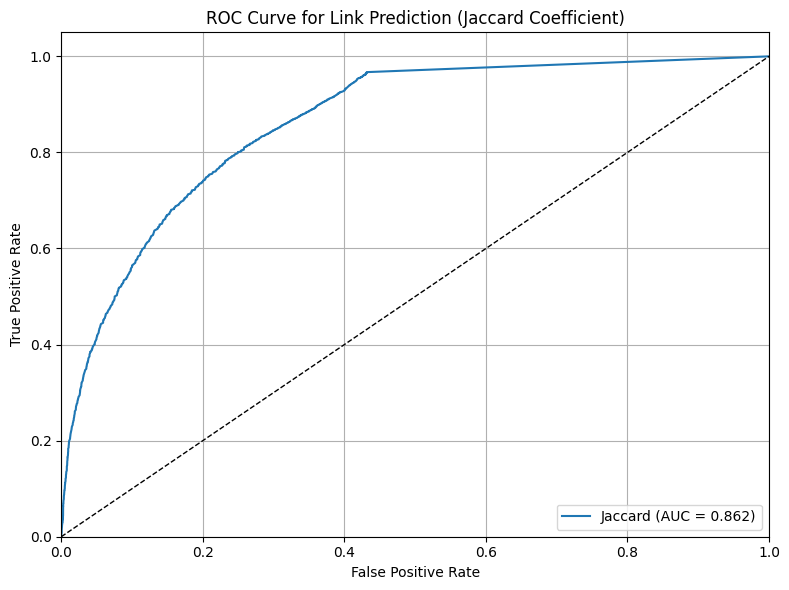

In [47]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from networkx.algorithms.link_prediction import jaccard_coefficient
import random

# Assume G is your undirected full graph
G = undirected_G.copy()

# Step 1: Create train/test split
edges = list(G.edges())
random.seed(42)
test_edges = random.sample(edges, int(0.1 * len(edges)))

G_train = G.copy()
G_train.remove_edges_from(test_edges)

# Step 2: Sample equal number of negative edges
non_edges = list(nx.non_edges(G_train))
negative_edges = random.sample(non_edges, len(test_edges))

# Step 3: Predict scores using Jaccard
edge_candidates = test_edges + negative_edges
pred_scores = list(jaccard_coefficient(G_train, edge_candidates))

# Step 4: Build ground truth and score arrays
y_true = [1] * len(test_edges) + [0] * len(negative_edges)
y_scores = [score for _, _, score in pred_scores]

# Step 5: Compute ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Step 6: Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Jaccard (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Link Prediction (Jaccard Coefficient)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
